## Retrieve the DNA sequeces from Ensembl using REST API
#### Upregulated genes by IFN (Positive Contorl)
#### Not regulated genes by IFN (Negative control)

#### Parse the positive control file and extract the gene_id, gene_name
#### Generate FASTA file

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

positive_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_IFN_up-regulation.csv"

with open(positive_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("Promoter_sequences_positive_control.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}")
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


/Users/sang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loaded 100 genes from CSV using index-based parsing.


## Scan motif in Promoter Region

In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_positive_threshold_10.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_positive_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=10.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_positive_threshold_10.0.csv


## Retrieve the negative control genes sequence from Ensembl using REST API

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

negative_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_no_IFN_regulation.csv"

with open(negative_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("Promoter_sequences_negative_control.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}")
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.


In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_negative_threshold_9.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_negative_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=9.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_negative_threshold_9.0.csv


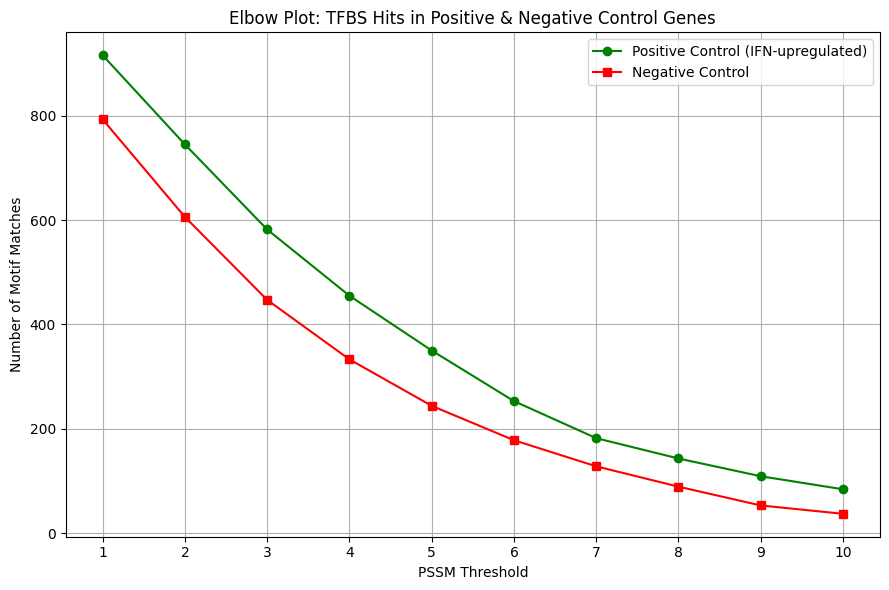

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define base paths
positive_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-1/outputs/positive"
negative_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-1/outputs/negative_con"

# Thresholds to evaluate
thresholds = range(1, 11)

# Empty lists to hold match counts
pos_hits = []
neg_hits = []

# Loop through thresholds
for threshold in thresholds:
    # Positive control output files
    pos_file = os.path.join(positive_path, f"motif_scan_positive_threshold_{threshold}.0.csv")
    if os.path.exists(pos_file):
        df_pos = pd.read_csv(pos_file)
        pos_hits.append(len(df_pos))
    else:
        pos_hits.append(0)

    # Negative control output files
    neg_file = os.path.join(negative_path, f"motif_scan_negative_threshold_{threshold}.0.csv")
    if os.path.exists(neg_file):
        df_neg = pd.read_csv(neg_file)
        neg_hits.append(len(df_neg))
    else:
        neg_hits.append(0)

# Plot both lines
plt.figure(figsize=(9, 6))
plt.plot(thresholds, pos_hits, marker='o', label="Positive Control (IFN-upregulated)", color="green")
plt.plot(thresholds, neg_hits, marker='s', label="Negative Control", color="red")

plt.xlabel("PSSM Threshold")
plt.ylabel("Number of Motif Matches")
plt.title("Elbow Plot: TFBS Hits in Positive & Negative Control Genes")
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Visualise the hit number by location

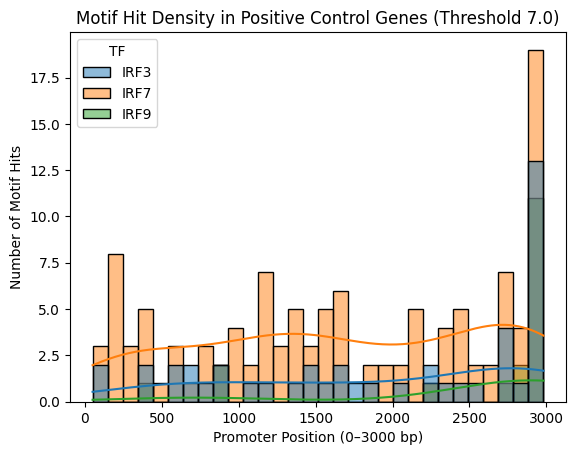

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pos_7 = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

sns.histplot(data = pos_7, bins=30, x='Start', hue= 'TF', kde=True)

plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Density in Positive Control Genes (Threshold 7.0)")
plt.show()

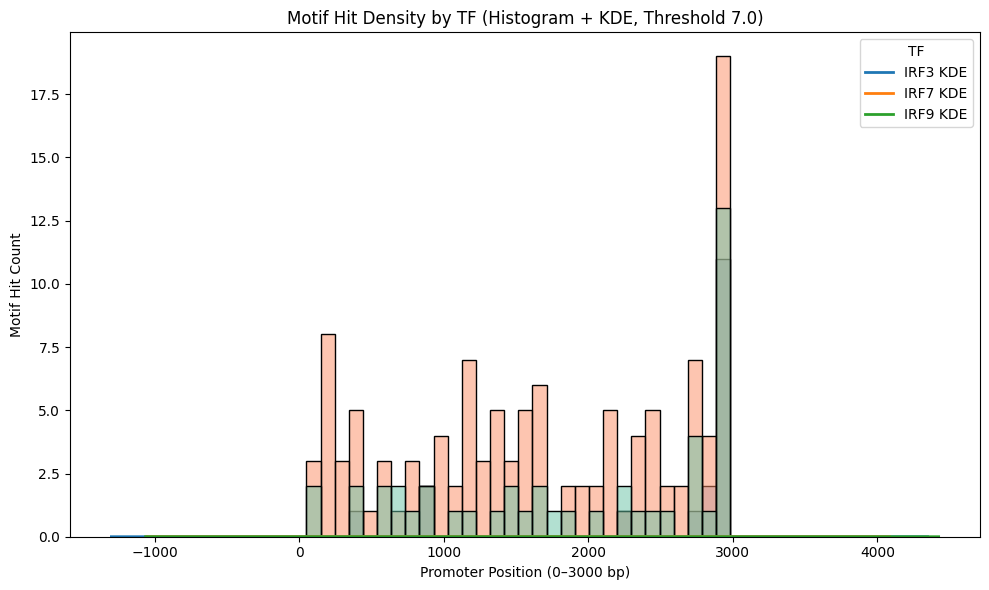

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Set figure
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(data=df, x="Start", hue="TF", bins=30, stat="count", common_norm=False, palette="Set2")

# Overlay correct KDE lines by looping
for tf in df["TF"].unique():
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        label=f"{tf} KDE",
        lw=2,
    )

# Labels and title
plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Motif Hit Count")
plt.title("Motif Hit Density by TF (Histogram + KDE, Threshold 7.0)")
plt.legend(title="TF")
plt.tight_layout()
plt.show()

#### Histogram and KDE density plot to see distribution of TFs

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/1480799023.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper left", title="TF")


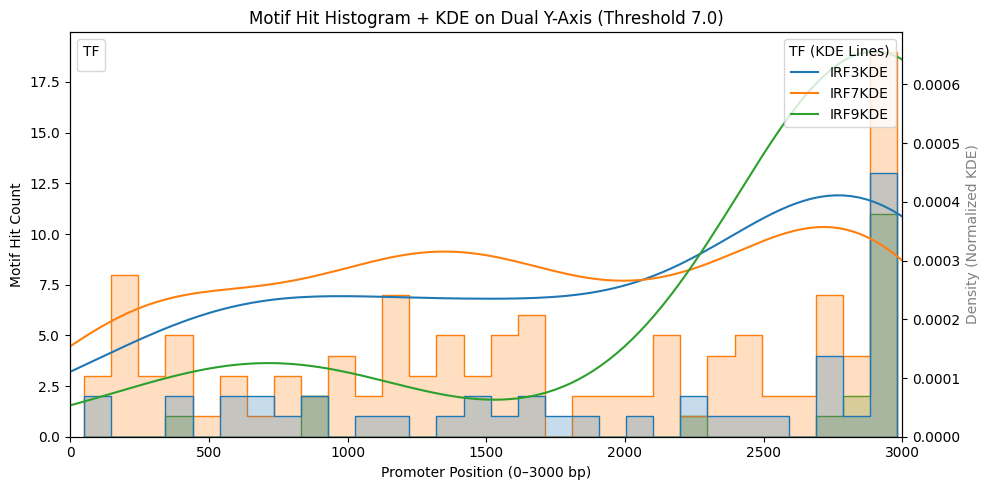

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot histogram on left y-axis (count)
sns.histplot(
    data=df,
    x="Start", # X-axis value
    hue="TF", # Show the different IRFs
    bins=30, # Divide the 3000 by 30
    ax=ax1,
    element="step", 
    stat="count",     # Raw count
    common_norm=False # Do not nomalise
)
ax1.set_ylabel("Motif Hit Count", color="black")
ax1.set_xlabel("Promoter Position (0–3000 bp)")

# Create second y-axis for KDE (density)
ax2 = ax1.twinx()

# Plot KDE curves on right y-axis
for tf in df["TF"].unique(): 
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        ax=ax2,
        label= tf + "KDE",
        fill=False,
        common_norm=True
    )

ax2.legend(title="TF (KDE Lines)", loc="upper right")
ax2.set_ylabel("Density (Normalized KDE)", color="gray")

# Titles and legend
plt.title("Motif Hit Histogram + KDE on Dual Y-Axis (Threshold 7.0)")
ax1.legend(loc="upper left", title="TF")
plt.xlim(0, 3000)
plt.tight_layout()
plt.show()

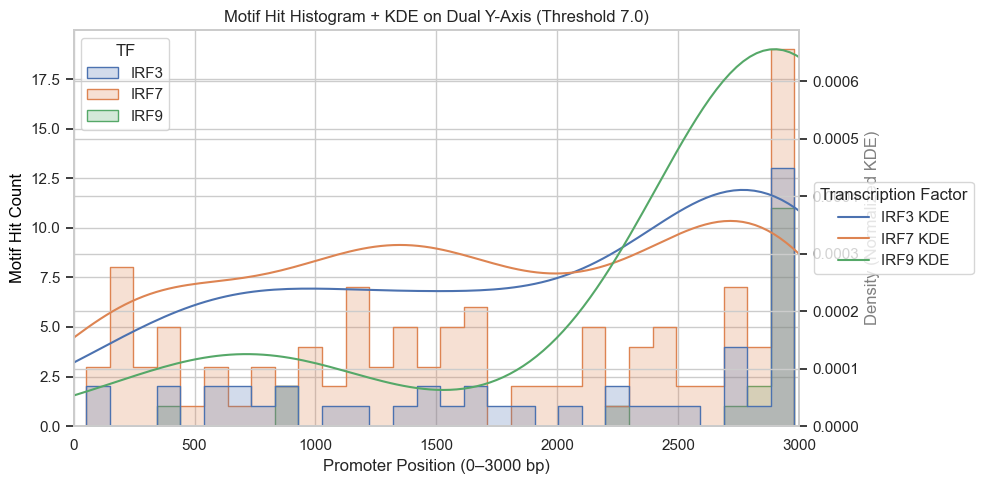

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load the data
df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot histogram on left y-axis (count)
sns.histplot(
    data=df,
    x="Start",
    hue="TF",
    bins=30,
    ax=ax1,
    element="step",
    stat="count",
    common_norm=False,
)

ax1.set_ylabel("Motif Hit Count", color="black")
ax1.set_xlabel("Promoter Position (0–3000 bp)")
ax1.set_xlim(0, 3000)

# Create second y-axis for KDE (density)
ax2 = ax1.twinx()

# Plot KDE curves on right y-axis
for tf in df["TF"].unique():
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        ax=ax2,
        label=f"{tf} KDE",
        fill=False,
        common_norm=True
    )

ax2.set_ylabel("Density (Normalized KDE)", color="gray")

# Combine legend entries from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Place combined legend on the right side
ax2.legend(
    handles=handles1 + handles2,
    labels=labels1 + labels2,
    title="Transcription Factor",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

# Title and layout
plt.title("Motif Hit Histogram + KDE on Dual Y-Axis (Threshold 7.0)")
plt.tight_layout()
plt.show()

#### Line plot to see the exact hit numbers between TFs

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_57664/2376518236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")


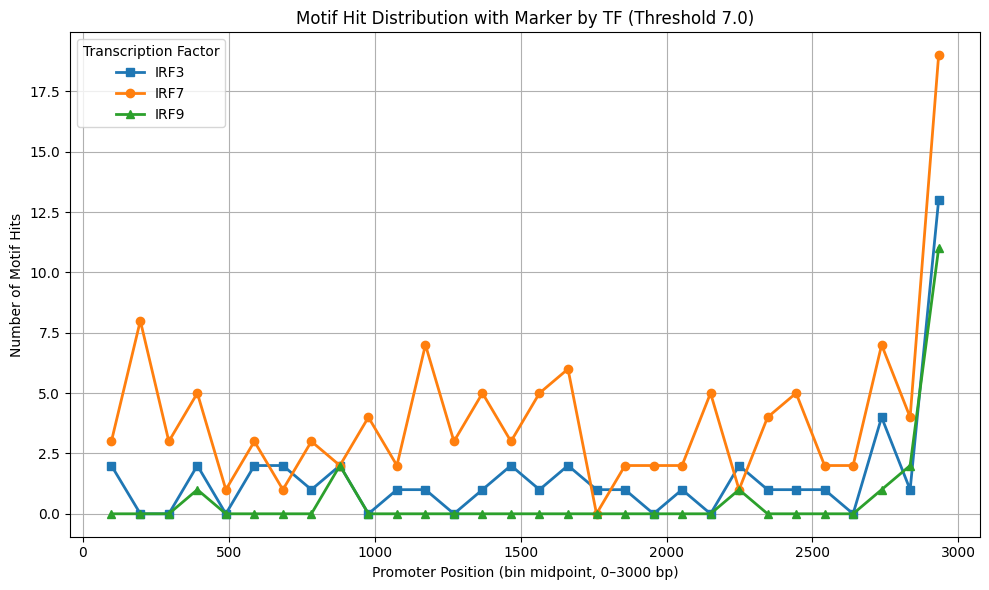

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the motif scan CSV
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# 2. Bin the 'Start' positions (0–3000bp into 30 bins)
df["bin"] = pd.cut(df["Start"], bins=30)

# 3. Group by TF and bin, count hits
counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")

# 4. Convert each bin to midpoint (x value)
counts["bin_mid"] = counts["bin"].apply(lambda x: x.mid)

# 5. Define custom markers for each TF
marker_map = {"IRF3": "s", "IRF7": "o", "IRF9": "^"}  # square, circle, triangle

# 6. Plot with Matplotlib (for full control)
plt.figure(figsize=(10, 6))

# 7. Loop through TFs and plot individually
for tf in counts["TF"].unique():
    subset = counts[counts["TF"] == tf]
    plt.plot(subset["bin_mid"], subset["count"],
             marker=marker_map[tf],  # shape for each TF
             label=tf,
             linestyle='-',          # connect with lines
             linewidth=2)

# 8. Customize the plot
plt.xlabel("Promoter Position (bin midpoint, 0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Distribution with Marker by TF (Threshold 7.0)")
plt.legend(title="Transcription Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_80208/2376518236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")


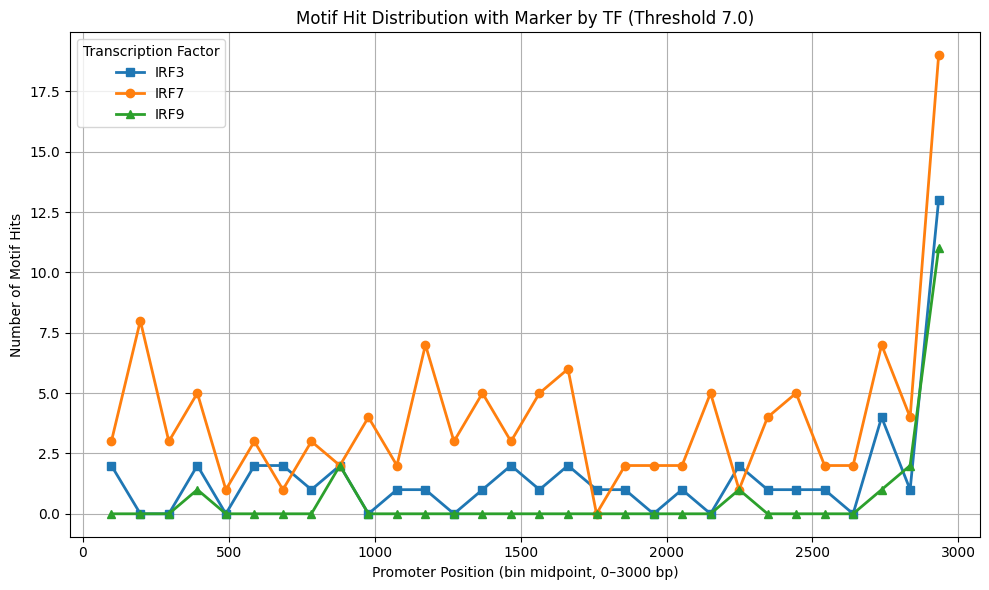

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the motif scan CSV
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# 2. Bin the 'Start' positions (0–3000bp into 30 bins)
df["bin"] = pd.cut(df["Start"], bins=30)

# 3. Group by TF and bin, count hits
counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")

# 4. Convert each bin to midpoint (x value)
counts["bin_mid"] = counts["bin"].apply(lambda x: x.mid)

# 5. Define custom markers for each TF
marker_map = {"IRF3": "s", "IRF7": "o", "IRF9": "^"}  # square, circle, triangle

# 6. Plot with Matplotlib (for full control)
plt.figure(figsize=(10, 6))

# 7. Loop through TFs and plot individually
for tf in counts["TF"].unique():
    subset = counts[counts["TF"] == tf]
    plt.plot(subset["bin_mid"], subset["count"],
             marker=marker_map[tf],  # shape for each TF
             label=tf,
             linestyle='-',          # connect with lines
             linewidth=2)

# 8. Customize the plot
plt.xlabel("Promoter Position (bin midpoint, 0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Distribution with Marker by TF (Threshold 7.0)")
plt.legend(title="Transcription Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

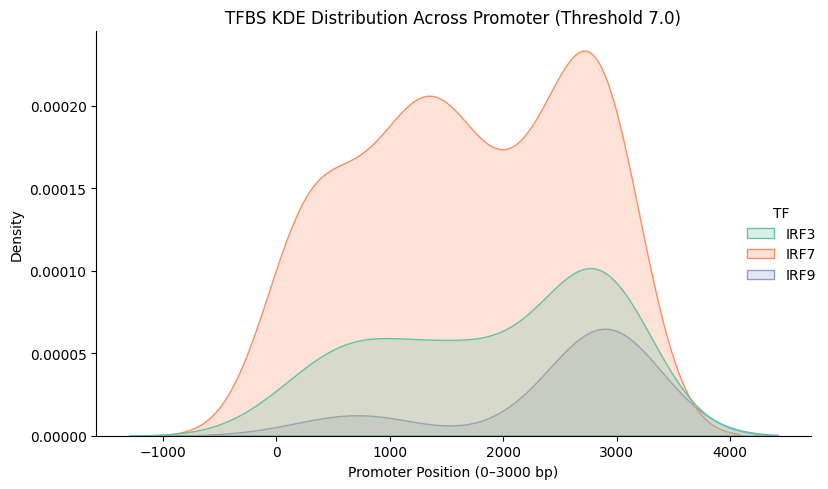

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Create the KDE plot using displot
sns.displot(
    data=df,
    x="Start",
    hue="TF",
    kind="kde",             # Smooth distribution
    height=5,
    aspect=1.5,
    multiple="layer",       # Overlay KDEs
    palette="Set2",
    fill=True               # Fill area under the curve (optional)
)

# Labeling must go under plt.gca() when using displot
plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Density")
plt.title("TFBS KDE Distribution Across Promoter (Threshold 7.0)")
plt.tight_layout()
plt.show()

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/3871992153.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["TF", "bin"]).size().reset_index(name="Count")


<Axes: xlabel='Mid', ylabel='Count'>

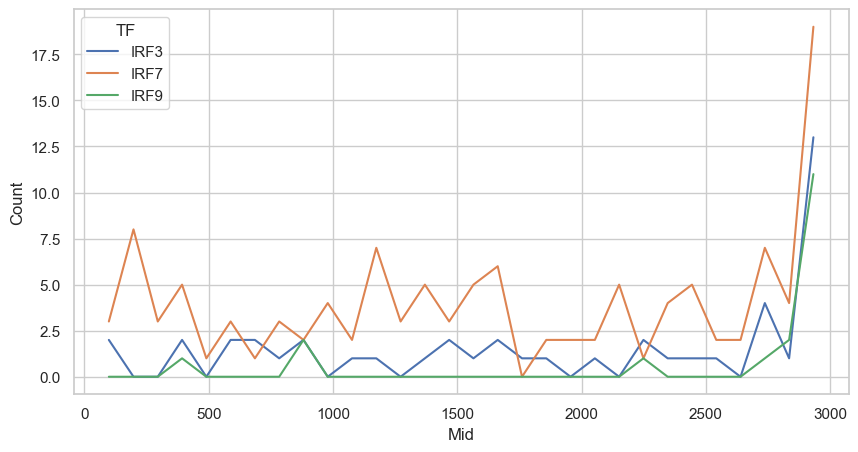

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Load data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Bin the 'Start' position into 30 equal bins from 0–3000 bp
df["bin"] = pd.cut(df["Start"], bins=30)

# Count number of hits per bin per TF
binned = df.groupby(["TF", "bin"]).size().reset_index(name="Count")

# Compute bin midpoints to use for x-axis
binned["Mid"] = binned["bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10, 5))
sns.lineplot(data=binned, x='Mid', y='Count', hue='TF', markers='o')